# Heatwave in the Netherlands

As an impact of global warming, an increase in temperature has been reported, which can lead to potential health risks and environmental stress. Several research studies have been presented over the years, such as in this [paper](https://www.mdpi.com/2072-4292/14/3/561), where they explain the change in Land surface temperature over several regions.

Thus, in this notebook, we want to showcase a tool for mapping heatwaves using Sentinel-3 products. For this, we focused on De Bilt in the Netherlands and used specific conditions proposed by the ["National Heatwave Plan"](https://www.rivm.nl/en/heat/national-heatwave-plan) in the Netherlands. The condition implies:

> 5 days >25
and
> 3 days >30

Moreover, in De Bilt where they had a temperature of 25°C at least five days in a row, with at least three days hotter than 30 °C 


https://nltimes.nl/2023/09/08/dutch-heat-record-broken-third-day-row-warm-sunny-weekend-ahead

In [2]:
import openeo

In [3]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


Let us load 5 month data for the area of interest

In [4]:
lst = connection.load_collection(
    "SENTINEL3_SLSTR_L2_LST",
    temporal_extent=["2023-06-01", "2023-10-30"],
    spatial_extent={"west": 5.0, "south": 52.0, "east": 5.16, "north": 52.17},
    bands=["LST_in:LST"],
)
lst = lst.rename_labels(dimension="bands", source=["LST_in:LST"], target=["LST"])

# apply offset and scaling
lst = 290 + (lst * 0.002)

Next, we define a User Defined Function (UDF) that takes in the datacube and checks whether both specified conditions are satisfied. Given that the unit of the Land Surface Temperature (LST) layer is Kelvin, the conditions are applied accordingly. If the values meet the designated threshold and continue for more than two days, a new resulting array is generated and returned.

Please note that, here we gave 298.15 and 303.15 Kelvin as two thresholds since we chose a relatively small region. You can change match your requirement. 

In [16]:
udf = openeo.UDF(
    """
import xarray
import numpy as np
from openeo.udf import XarrayDataCube, inspect

def apply_datacube(cube: XarrayDataCube, context: dict) -> XarrayDataCube:

    array_x = cube.get_array()
    
    array = array_x.values
    inspect(data=[array.shape], message = "Array dimensions")
    res_arr=np.zeros(array.shape)
    for i in range(array.shape[0]-4):
        ar_sub=np.take(array,  range(i, i+5), axis=0)
        res_arr[i]=(np.all(ar_sub>295,axis=0)) & (np.nansum(ar_sub>300,axis=0)>2)
    return XarrayDataCube(
        array=xarray.DataArray(res_arr, dims=array_x.dims, coords=array_x.coords)
    )
"""
)

In [17]:
heatwave_loc = lst.apply_dimension(process=udf, dimension="t")

Now let us use `sum` as the reducer to count the total number of times each pixels had a heat wave in the Netherlands during June-September 2023.

In [18]:
heatwave_loc = heatwave_loc.reduce_dimension(reducer="sum", dimension="t")

In [19]:
heatwave_loc.execute_batch(
    title="Heatwave Locations in  De Bilt", outputfile="Heatwave.nc"
)

0:00:00 Job 'j-2401313ca3524e84874fa5c5f2695243': send 'start'
0:00:22 Job 'j-2401313ca3524e84874fa5c5f2695243': created (progress N/A)
0:00:27 Job 'j-2401313ca3524e84874fa5c5f2695243': created (progress N/A)
0:00:34 Job 'j-2401313ca3524e84874fa5c5f2695243': created (progress N/A)
0:00:42 Job 'j-2401313ca3524e84874fa5c5f2695243': running (progress N/A)
0:00:52 Job 'j-2401313ca3524e84874fa5c5f2695243': running (progress N/A)
0:01:05 Job 'j-2401313ca3524e84874fa5c5f2695243': running (progress N/A)
0:01:20 Job 'j-2401313ca3524e84874fa5c5f2695243': running (progress N/A)
0:01:40 Job 'j-2401313ca3524e84874fa5c5f2695243': running (progress N/A)
0:02:04 Job 'j-2401313ca3524e84874fa5c5f2695243': running (progress N/A)
0:02:34 Job 'j-2401313ca3524e84874fa5c5f2695243': running (progress N/A)
0:03:18 Job 'j-2401313ca3524e84874fa5c5f2695243': running (progress N/A)
0:04:05 Job 'j-2401313ca3524e84874fa5c5f2695243': running (progress N/A)
0:05:04 Job 'j-2401313ca3524e84874fa5c5f2695243': running (pr

<BatchJob job_id='j-2401313ca3524e84874fa5c5f2695243'>

## Let's plot the results

In [20]:
import matplotlib.pyplot as plt
import xarray as xr

In [21]:
heatwave = xr.load_dataset("Heatwave.nc")

In [22]:
heatwave

<xarray.Dataset>
Dimensions:  (x: 18, y: 20)
Coordinates:
  * x        (x) float64 5.004 5.013 5.022 5.031 ... 5.129 5.138 5.147 5.156
  * y        (y) float64 52.17 52.16 52.15 52.14 52.13 ... 52.02 52.01 52.0 52.0
Data variables:
    crs      |S1 b''
    LST      (y, x) float32 0.0 0.0 0.0 1.0 1.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 nan
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform - Geotrellis backend: 0.24.0a1
    description:  
    title:

In [23]:
data = heatwave[["LST"]].to_array(dim="bands")

Text(0.5, 1.0, '# of Days with Heatwave in 2023')

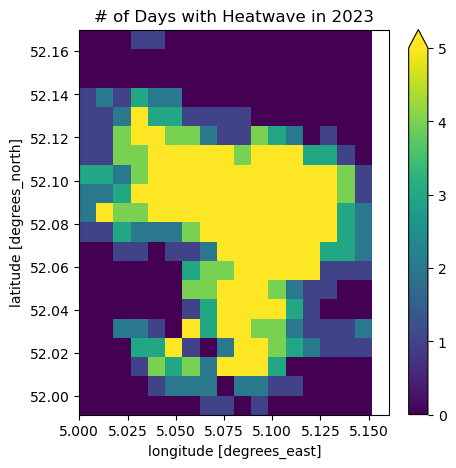

In [24]:
fig, axes = plt.subplots(ncols=1, figsize=(5, 5), dpi=100, sharey=True)
data[0].plot.imshow(vmin=0, vmax=5, ax=axes)
axes.set_title("# of Days with Heatwave in 2023")

The above plot shows the number of days with a heatwave in the area of interest in the specified time interval.